# Data Methods for Health Research Assignment

- Candidate: CFLK1
- Github URL: https://github.com/CFLK1/DMHR-18-19/blob/master/DMHR-CHME0013_CFLK1.ipynb

In [1]:
# import necessary libraries for the whole assignment
import pandas as pd
import numpy as np
from math import floor
from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt

## Assignment A

In [2]:
# Import all the files needed in Assignment A

# Import "prescription data" file as data frame
prescribe_cols = ["sha", "pct", "prac_code", "bnf_code", "bnf_name", "items", "nic", "act_cost", "quantity", "period"]
prescribe_apr2018 = pd.read_csv("C:/UCL_DMHR/T201804PDPI+BNFT.csv", skiprows=1, names=prescribe_cols, index_col=False)

# Import "code, names, address" file as data frame
address_cols = ["period", "prac_code", "prac_name", "prac_org", "street", "city", "area", "postcode"]
address_apr2018 = pd.read_csv("C:/UCL_DMHR/T201804ADDR+BNFT.csv", names=address_cols, index_col=False)
# The address recording format is inconsistent, be careful when slicing

# Import "BNF code up to #8&9 (chemical substance), chemical name" file as data frame
chemical_cols = ["bnf_chem_sub", "chem_name"]
chemical_apr2018 = pd.read_csv("C:/UCL_DMHR/T201804CHEM+SUBS.csv", skiprows=1, names=chemical_cols,\
                               index_col=False).rename(columns=lambda x: x.strip())

# Import "patient data" file as data frame
patient_cols = ["publication", "extract_date", "type", "ccg_code", "ons_ccg_code", "prac_code", "postcode", "sex", "age",\
                "npatients"]
patient_apr2018 = pd.read_csv("C:/UCL_DMHR/gp-reg-pat-prac-all.csv", skiprows=1, names=patient_cols, index_col=False)

In [3]:
# inspect data
print(prescribe_apr2018.info())
print(address_apr2018.info())
print(chemical_apr2018.info())
print(patient_apr2018.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9748354 entries, 0 to 9748353
Data columns (total 10 columns):
sha          object
pct          object
prac_code    object
bnf_code     object
bnf_name     object
items        int64
nic          float64
act_cost     float64
quantity     int64
period       int64
dtypes: float64(2), int64(3), object(5)
memory usage: 743.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 8 columns):
period       9578 non-null int64
prac_code    9578 non-null object
prac_name    9578 non-null object
prac_org     9578 non-null object
street       9578 non-null object
city         9578 non-null object
area         9578 non-null object
postcode     9578 non-null object
dtypes: int64(1), object(7)
memory usage: 598.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3496 entries, 0 to 3495
Data columns (total 2 columns):
bnf_chem_sub    3496 non-null object
chem_name       3496 non-null object
dtype

In [4]:
# check nulls
print(prescribe_apr2018.isnull().sum())
print(address_apr2018.isnull().sum())
print(chemical_apr2018.isnull().sum())
print(patient_apr2018.isnull().sum())

sha          0
pct          0
prac_code    0
bnf_code     0
bnf_name     0
items        0
nic          0
act_cost     0
quantity     0
period       0
dtype: int64
period       0
prac_code    0
prac_name    0
prac_org     0
street       0
city         0
area         0
postcode     0
dtype: int64
bnf_chem_sub    0
chem_name       0
dtype: int64
publication     0
extract_date    0
type            0
ccg_code        0
ons_ccg_code    0
prac_code       0
postcode        0
sex             0
age             0
npatients       0
dtype: int64


In [5]:
# check nulls if blank cells (with whitespace only) are converted to NaN
print(prescribe_apr2018.replace(r'^\s+$', np.nan, regex=True).isnull().sum())
print(address_apr2018.replace(r'^\s+$', np.nan, regex=True).isnull().sum())
print(chemical_apr2018.replace(r'^\s+$', np.nan, regex=True).isnull().sum())
print(patient_apr2018.replace(r'^\s+$', np.nan, regex=True).isnull().sum())

sha          0
pct          0
prac_code    0
bnf_code     0
bnf_name     0
items        0
nic          0
act_cost     0
quantity     0
period       0
dtype: int64
period          0
prac_code       0
prac_name       0
prac_org        4
street        688
city          363
area         1918
postcode        0
dtype: int64
bnf_chem_sub    0
chem_name       0
dtype: int64
publication     0
extract_date    0
type            0
ccg_code        0
ons_ccg_code    0
prac_code       0
postcode        0
sex             0
age             0
npatients       0
dtype: int64


No important missing values detected. Many cells in addresses are blank likely due to recording inconsistencies. Using addresses to slice out specific areas/cities is not ideal.

### A1. Identify all GP practices located in London. For those practices, describe:
- the total number of patients registered
- the total number of prescriptions
- the total actual cost of these prescriptions (using the ACT COST column)
- the top 10 most frequent drugs prescribed
- the bottom 10 less frequent drugs prescribed

In [6]:
London_patient = patient_apr2018[patient_apr2018["ccg_code"].str.match("07[L-Y]|08[A-Y]|09A")].copy(deep=True)
Lon_tot_pat = London_patient["npatients"].sum()
print("%d patients registered at a London GP in April 2018." % Lon_tot_pat)

9851208 patients registered at a London GP in April 2018.


In [7]:
London_prescribe = prescribe_apr2018[prescribe_apr2018["prac_code"].isin(London_patient["prac_code"])].copy(deep=True)
Lon_tot_presc = London_prescribe["items"].sum()
print("%d items were prescribed in all London GPs in April 2018." % Lon_tot_presc)
print("Items prescribed this month can be approximated by %.2f per patient registered." % (Lon_tot_presc/Lon_tot_pat))

10416926 items were prescribed in all London GPs in April 2018.
Items prescribed this month can be approximated by 1.06 per patient registered.


In [8]:
Lon_tot_cost = London_prescribe["act_cost"].sum()
print("£%.2f was spent for these prescriptions in April 2018." % Lon_tot_cost)
print("This converts to £%.2f spent per patient." % (Lon_tot_cost/Lon_tot_pat))

£76586738.71 was spent for these prescriptions in April 2018.
This converts to £7.77 spent per patient.


In [9]:
London_total_drug = pd.DataFrame(London_prescribe.groupby(London_prescribe.bnf_name).apply(lambda subf: subf["items"].sum()))
London_total_drug.columns = ["total_items"]
London_total_drug.reset_index(inplace=True)
London_total_drug.sort_values(by=["total_items"], ascending=False).iloc[:10, :]

,bnf_name,total_items
9237,Omeprazole_Cap E/C 20mg,239181
8206,Metformin HCl_Tab 500mg,208077
705,Amlodipine_Tab 5mg,198244
997,Atorvastatin_Tab 20mg,182749
969,Aspirin Disper_Tab 75mg,168671
704,Amlodipine_Tab 10mg,155573
999,Atorvastatin_Tab 40mg,152003
7202,Lansoprazole_Cap 30mg (E/C Gran),149520
11008,Salbutamol_Inha 100mcg (200 D) CFF,140534
9651,Paracet_Tab 500mg,123526


In [10]:
print(London_total_drug.sort_values(by=["total_items"]).iloc[:10, :])
len(London_total_drug[London_total_drug["total_items"] == 1])
# 2155 drug presentations with only 1 item prescribed

                                       bnf_name  total_items
13699  varicase Class 2 Thigh Open Toe Slc Band            1
7082   KytoCel 10cm x 10cm Wound Dress Protease            1
7076   Konakion MM_I/V Inj 10mg/ml 1ml Amp                 1
7072   KoCarbon Occlusive 4cmx6.4cm Wound Dress            1
7069   Knit-Band 15cm x 4m Ktd Polyam & Cellulo            1
7065   Kliniderm fiber cmc 5cm x 5cm Wound Dres            1
7058   Kliniderm Foam Slc Border 10cm x 30cm Wo            1
7039   Ketoconazole_Tab 200mg                              1
7034   KetoClassic 3:1_Meal Pouch 135g (Chkn)              1
7025   Ketamine_Inj 10mg/ml 20ml Vl                        1


2155

### A2. Repeat the previous instructions, this time for the city of Cambridge. Discuss and compare findings with the answers for London.

In [11]:
Cambridge_patient = patient_apr2018[(patient_apr2018["ccg_code"] == "06H") &\
                                    (patient_apr2018["postcode"].str.match("[C][B][1-5][A-Z]?\s[0-9][A-Z]{2}"))].copy(deep=True)
Cam_tot_pat = Cambridge_patient["npatients"].sum()
print("%d patients registered at a Cambridge city GP in April 2018." % Cam_tot_pat)

191931 patients registered at a Cambridge city GP in April 2018.


In [12]:
Cambridge_prescribe = prescribe_apr2018[prescribe_apr2018["prac_code"].isin(Cambridge_patient["prac_code"])].copy(deep=True)
Cam_tot_presc = Cambridge_prescribe["items"].sum()
print("%d items were prescribed in all Cambridge city GPs in April 2018." % Cam_tot_presc)
print("Items prescribed this month can be approximated by %.2f per patient registered." % (Cam_tot_presc/Cam_tot_pat))

160494 items were prescribed in all Cambridge city GPs in April 2018.
Items prescribed this month can be approximated by 0.84 per patient registered.


In [13]:
Cam_tot_cost = Cambridge_prescribe["act_cost"].sum()
print("£%.2f was spent for these prescriptions in April 2018." % Cam_tot_cost)
print("This converts to £%.2f spent per patient." % (Cam_tot_cost/Cam_tot_pat))

£1227048.96 was spent for these prescriptions in April 2018.
This converts to £6.39 spent per patient.


In [14]:
Cambridge_total_drug = pd.DataFrame(Cambridge_prescribe.groupby(Cambridge_prescribe.bnf_name)\
                                    .apply(lambda subf: subf[["items"]].sum()))
Cambridge_total_drug.columns = ["total_items"]
Cambridge_total_drug.reset_index(inplace=True)
Cambridge_total_drug.sort_values(by=["total_items"], ascending=False).iloc[:10, :]

,bnf_name,total_items
2958,Omeprazole_Cap E/C 20mg,5063
294,Atorvastatin_Tab 20mg,3158
276,Aspirin Disper_Tab 75mg,2476
206,Amlodipine_Tab 5mg,2268
3546,Salbutamol_Inha 100mcg (200 D) CFF,2149
3086,Paracet_Tab 500mg,2093
2536,Metformin HCl_Tab 500mg,1907
1657,Folic Acid_Tab 5mg,1816
200,Amitriptyline HCl_Tab 10mg,1703
2266,Levothyrox Sod_Tab 25mcg,1657


In [15]:
print(Cambridge_total_drug.sort_values(by=["total_items"]).iloc[:10, :])
len(Cambridge_total_drug[Cambridge_total_drug["total_items"] == 1])
# 644 drug presentations with only 1 item prescribed

                                      bnf_name  total_items
0     365 Strips Skin Closure Strips Ster Surg            1
2108  Isotard 40 XL_Tab 40mg                              1
2094  Isosorbide Dinit_Tab 20mg                           1
2093  Isosorbide Dinit_Tab 10mg                           1
2091  Ismo 20_Tab 20mg                                    1
2090  IryCone+ Irrig System                               1
2085  Irbesartan/Hydchloroth_Tab 300mg/25mg               1
2077  Intuniv_Tab 3mg M/R                                 1
2074  Insupen Needles Pen Inj Screw On 4mm/33             1
2070  Insight 2 Tube Holder Tracheo TH100                 1


1206

# Technical Report:
- There are multiple ways to define London, such as postcodes and addresses. However, after inspection of addresses, it is found that “London” is inconsistently recorded as “area” or “city” and GPs in grey areas such as Watford are differential in whether they regard themselves as “London” in their addresses. Postcode is a more robust identifier, although it is still arguable whether or not to consider Greater London on top of the 8 postcodes corresponding to Central London. In this case, since the NHS clinical commissioning group (CCG) codes are available in the patient dataset, using this may be more informative for planning and commissioning healthcare. The CCG codes corresponding to the London Commissioning Board range from “07L” to “09A” (https://www.england.nhs.uk/ccg-details/). This method returns 9,851,208 patients registered at a London GP in April 2018. For comparison, the Office for National Statistics (ONS) reported a population estimate of 8.8 million in London in 2017 (https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/censusoutputareaestimatesinthelondonregionofengland). Despite a slightly different time point and possible variation in defining the region, the number of registration records for London identified by this method is comparable and likely valid, while the overestimation may additionally be attributed to record confusions and immigration.
- Similarly, the CCG code was used to define the city of Cambridge. However, there is only one code “06H” that corresponds to the whole Cambridgeshire. To further restrict the area to the city, the corresponding postcode areas of CB1 to CB5 was used in combination. This returns 191,931 patients registered at a Cambridge city GP in April 2018. The population of the city of Cambridge was approximated at 123,900 in 2011 (https://www.cambridge.gov.uk/2011-census). Again, after considering population growth, possible variation in region definition and the nature of registration records, this number is comparable with slight overestimation which supports the validity of this method.
- Across all London GPs, 10,416,926 items were prescribed in April 2018 which converts to 1.06 items per patient. In Cambridge city, 160,494 items were prescribed in April 2018 which converts to 0.84 items per patient. For GPs in both regions, the item prescribed in this month can be approximated by around 1 per patient registered, even though we do not have data on patient visits.
- In London, £76586738.71 was spent for these prescriptions which equals to an average of £7.77 per patient registered. In Cambridge city this was £1227048.96 with an average of £6.39 spent per patient registered, which is £1.38 slightly lower than that of London.
- Among the top 10 drugs prescribed in London, Omeprazole and Lansoprazole are commonly prescribed for stomach and oesophagus problems like acid reflux. Amlodipine, a drug for lowering blood pressure, and atorvastatin, a drug for reducing high blood cholesterol, are on the top 10 list in two different presentations, making them the most commonly prescribed chemicals in London. Metformin is a drug for type 2 diabetes. Salbutamol is a drug for asthma and breathlessness. Aspirin and Paracet are common pain killers, but aspirin is sometimes prescribed to reduce risks of cardiovascular events. The results suggest that chronic diseases including cardiovascular problems and diabetes constitute a major health care burden in London in terms of common prescriptions. Gastric reflux can be results of stress and busy lifestyle that leads to irregular dietary habits, which can be common in a big city like London. 
- For Cambridge city, the same drugs are Omeprazole for acid reflux, Atorvastatin for high blood cholesterol, Amlodipine for hypertension, Salbutamol for asthma, Metformin for diabetes, Aspirin and Paracet for general pain. Similarly, cardiovascular conditions are a major health care burden in Cambridge city. In addition, several different drugs are on the list including Folic acid for anaemia and prophylaxis of multiple diseases, Amitriptyline for pain and migraine, and Levothyrox for thyroid hormone deficiency.
- The least prescribed items for both London and Cambridge city are not very informative because there are 2155 and 1206 items that were prescribed just once respectively in April 2018. These include some accessories for specialised conditions as seen in the printed examples.

### A3. Describe total number of prescriptions and their total actual cost (using the ACT COST column) across all practices for drugs related to:
- cardiovascular disease (British National Formulary chapter 2)
- antidepressants (British National Formulary chapter 4.3)

In [16]:
# create a table with items and cost grouped by BNF codes
All_drug_cost = pd.DataFrame(prescribe_apr2018.groupby(prescribe_apr2018.bnf_code)\
                             .apply(lambda subf: subf[["items", "act_cost"]].sum()))
All_drug_cost.columns = ["total_items", "total_act_cost"]
All_drug_cost.reset_index(inplace=True)
print(All_drug_cost.shape)
All_drug_cost.head()

(22358, 3)


,bnf_code,total_items,total_act_cost
0,0101010C0AAAAAA,169.0,1783.49
1,0101010C0BBAAAA,310.0,3054.91
2,0101010F0AAAUAU,23.0,3493.48
3,0101010G0AAABAB,1911.0,6411.46
4,0101010G0AAAGAG,158.0,571.66


In [17]:
# for CVD
All_cvd = All_drug_cost[All_drug_cost["bnf_code"].str.startswith("02")]
cvd_items = All_cvd["total_items"].sum()
cvd_cost = All_cvd["total_act_cost"].sum()
print("%d items related to cardiovascular disease were prescribed, costing £%.2f with an average of £%.2f per item." \
      % (cvd_items, cvd_cost, cvd_cost/cvd_items))

26449832 items related to cardiovascular disease were prescribed, costing £90193834.02 with an average of £3.41 per item.


In [18]:
# for antidepressants
All_antidepr = All_drug_cost[All_drug_cost["bnf_code"].str.startswith("0403")]
antidepr_items = All_antidepr["total_items"].sum()
antidepr_cost = All_antidepr["total_act_cost"].sum()
print("%d antidepressant items were prescribed, costing £%.2f with an average of £%.2f per item." \
      % (antidepr_items, antidepr_cost, antidepr_cost/antidepr_items))

5715873 antidepressant items were prescribed, costing £16853470.86 with an average of £2.95 per item.


# Technical Report:
- 26,449,832 items related to cardiovascular disease were prescribed, costing £90,193,834.02 with an average of £3.41 per item. 5,715,873 antidepressant items were prescribed, costing £16,853,470.86 with an average of £2.95 per item. There are more items for cardiovascular conditions prescribed than antidepressant and they cost more. 

### A4. Describe the total spending and the relative costs per patient across all practices for the month of April 2018

In [19]:
# creating a new data frame for total spendings and patient numbers by practice
All_prac_cost = pd.DataFrame(prescribe_apr2018.groupby(prescribe_apr2018.prac_code).apply(lambda subf: subf[["act_cost"]].sum()))
All_prac_cost.columns = ["total_act_cost"]
All_prac_cost.reset_index(inplace=True)

All_prac_cost_pat = pd.merge(All_prac_cost, patient_apr2018[["prac_code", "npatients"]], left_on="prac_code",\
                             right_on="prac_code")
print(All_prac_cost_pat.shape)
All_prac_cost_pat.head()

(7191, 3)


,prac_code,total_act_cost,npatients
0,A81001,52194.63,4086
1,A81002,268607.26,19906
2,A81004,139115.40,10165
3,A81005,102914.06,8016
4,A81006,183226.79,14497


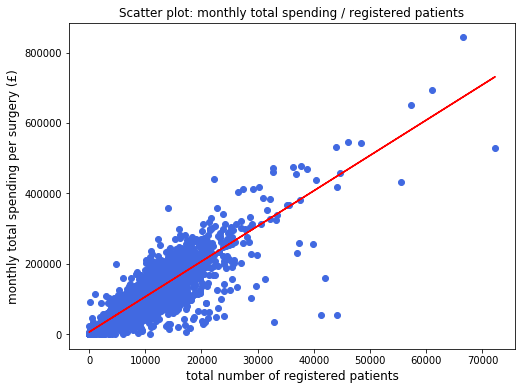

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
x = All_prac_cost_pat["npatients"]
y = All_prac_cost_pat["total_act_cost"]
ax.scatter(x, y, color="royalblue")
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color="red")
ax.set_title("Scatter plot: monthly total spending / registered patients")
ax.set_xlabel("total number of registered patients", fontsize=12)
ax.set_ylabel("monthly total spending per surgery (£)", fontsize=12)
plt.show()

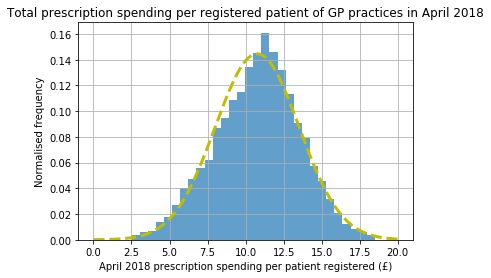

Excluding 1% outliers on both sides, the resulting distribution has mean £10.76 and standard deviation £2.76.


In [21]:
cost_patient_plot = All_prac_cost_pat
cost_patient_plot["cost_per_patient"] = cost_patient_plot["total_act_cost"] / cost_patient_plot["npatients"] 

quantile_01 = cost_patient_plot["cost_per_patient"].quantile(.01)
quantile_99 = cost_patient_plot["cost_per_patient"].quantile(.99)

no_outliers = cost_patient_plot[(cost_patient_plot["cost_per_patient"].values <= quantile_99) &\
                                (cost_patient_plot["cost_per_patient"].values >= quantile_01)]["cost_per_patient"]
plt.hist(no_outliers, bins=30, density=True, alpha=0.7)

# find minimum and maximum of xticks to know range of theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(no_outliers))

# normal distribution
mean, std = norm.fit(no_outliers) # get mean and standard deviation  
pdf_g = norm.pdf(lnspc, mean, std) # get theoretical values in interval  
plt.plot(lnspc, pdf_g, "y--", linewidth=3, label="Norm") # plotting

plt.title("Total prescription spending per registered patient of GP practices in April 2018")
plt.xlabel("April 2018 prescription spending per patient registered (£)")
plt.ylabel("Normalised frequency")
plt.grid(True)

plt.show()
print("Excluding 1%% outliers on both sides, the resulting distribution has mean £%.2f and standard deviation £%.2f." \
     % (mean, std))

In [22]:
# inspecting the outliers
outliers = cost_patient_plot[(cost_patient_plot["cost_per_patient"].values > quantile_99) |\
                                (cost_patient_plot["cost_per_patient"].values < quantile_01)]

print(outliers.shape)
outliers.sort_values(by=["cost_per_patient"], ascending=False).head()

(144, 4)


,prac_code,total_act_cost,npatients,cost_per_patient
6983,Y02045,22640.16,8,2830.020000
7095,Y02873,4295.03,3,1431.676667
6977,Y01924,90691.01,106,855.575566
2588,F81608,3099.81,14,221.415000
7047,Y02645,835.28,6,139.213333


In [23]:
# finding the practice with the highest cost per patient among the outliers
address_apr2018[address_apr2018["prac_code"] == "Y02045"].iloc[:,2:7]

,prac_name,prac_org,street,city,area
7446,VERNOVA HEALTHCARE CIC,WATERS GREEN MEDICAL CTR,SUNDERLAND STREET,MACCLESFIELD,CHESHIRE


In [24]:
# inspecting the most costly items of Vernova Healthcare CIC
prescribe_apr2018[prescribe_apr2018["prac_code"] == "Y02045"].sort_values(by="act_cost").iloc[:,4:8].tail(10)

,bnf_name,items,nic,act_cost
37680,Tacrolimus_Oint 0.1%,10,413.28,383.40
37530,Rifampicin_Cap 300mg,3,450.89,418.39
37706,Aldara_Crm 5% Sach 250mg,5,453.60,420.92
37709,Fluorouracil_Crm 5%,16,526.40,488.38
37710,Efudix_Crm 5%,26,855.40,793.61
37700,Roaccutane_Cap 20mg,21,1077.09,999.66
37673,Enstilar_Foam Aero 50mcg/0.5mg/g,25,1230.08,1141.07
37577,Ciclosporin_Cap 100mg,6,1493.05,1385.01
37768,FreeStyle Libre Sensor Kit,29,2065.00,1915.42
37698,Isotretinoin_Cap 20mg,59,2742.23,2546.07


In [25]:
# calculating the contribution of the top 5 presentations in the practice's total spending
prescribe_apr2018[prescribe_apr2018["prac_code"] == "Y02045"].sort_values(by="act_cost").iloc[-5:,7].sum()/22640.16

0.35279035130493774

In [26]:
# inspecting the lower end of the cost per patient outliers
outliers.sort_values(by=["cost_per_patient"], ascending=False).tail()

,prac_code,total_act_cost,npatients,cost_per_patient
647,B83044,3.38,483,0.006998
3429,G83064,8.57,2406,0.003562
760,B85638,8.42,4109,0.002049
6418,P81740,3.81,1892,0.002014
4707,L81080,18.80,10908,0.001724


In [27]:
# finding the practice with the lowest cost per patient among the outliers
address_apr2018[address_apr2018["prac_code"] == "L81080"].iloc[:,2:7]

,prac_name,prac_org,street,city,area
4302,ST.JAMES'S SURGERY,45 UPPER OLDFIELD PARK,,BATH,


In [28]:
# inspecting all the items prescribed by this surgery in April 2018
prescribe_apr2018[prescribe_apr2018["prac_code"] == "L81080"].sort_values(by="act_cost").iloc[:,4:8]

,bnf_name,items,nic,act_cost
7468347,Fluoxetine HCl_Cap 20mg,1,0.58,0.55
7468345,Losartan Pot_Tab 50mg,1,1.14,1.07
7468348,Codeine Phos_Tab 15mg,1,1.30,1.22
7468346,Amlodipine_Tab 5mg,1,1.43,1.34
7468349,Tramadol HCl_Cap 50mg,1,2.46,2.39
7468352,Colecal_Cap 800u,1,3.36,3.23
7468350,Rigevidon_Tab,1,3.78,3.52
7468351,Desogestrel_Tab 75mcg,1,5.90,5.48


# Technical Report:
- We are interested in the total spending and costs per patient registered across all GPs (n = 7191) in April 2018.
- From the scatter plot of monthly total spending per surgery against total number of their registered patients, a clear trend of higher spending with more registered patients can be observed as represented by the fitted trend line. This is reasonable as having a larger registered patient pool would likely lead to more patient visits and thus more prescribed items. The majority of practices fall below around 30,000 registered patients and under £400,000 spending, while a few GPs seem to operate in a larger scale with higher expenditure. There are a couple of suspicious outliers that have many registered patients but with minimal spending, or have very few patients but an unusually high spending.
- To further study the distribution of spending per patient registered, a histogram is plotted for the data with a fitted Gaussian curve. This data was modified by removing 1% outliers on both sides of the distribution. The resulting data is roughly normal with minor negative skewness, which means there is slightly more observations at lower spending per patient. The mean is £10.76 and the standard deviation is £2.76. London and Cambridge city fall onto the lower spending per patient registered side with £7.77 and £6.39 respectively.
- It is worth looking into the outliers as they may indicate recording errors, problem in the system or true exceptional cases that the NHS may want to consider when making decisions. Among the 144 (2%) extreme GPs, the spending per patient is as high as £2,830.02 or as low as £0.0017. The highest data came from Vernova Healthcare in Macclesfield which is a community interest company owned by 22 practices and provides specialised services such as dermatology and diabetes care (http://www.vernovahealthcare.org/about-us/). This service model may partially explain the mere 8 patients registered. Looking at their prescription spending, the highest 5 presentations made up more than one-third of their £22640.16 total spending. These turn out to be expensive items for severe acne (Isotretinoin, Roaccutane), immunosuppressant drugs possibly for inflammatory skin diseases (Ciclosporin, Tacrolimus), psoriasis (Enstilar), skin cancer or cancer in general (Fluorouracil, Efudix, Aldara), tuberculosis or other bacteria infections (rifampicin) and diabetes management by glucose monitoring (FreeStyle Libre Sensor Kit). The lowest data came from St. James Surgery in Bath, which only had 8 items prescribed in April 2018 despite having 10,908 registered patients. Cases like this may need further inspection.


## Assignment B

In [29]:
# import necessary files as data frames
# import "mortality file 1"
mortality_allyrs_1 = pd.read_csv("C:/UCL_DMHR/Morticd10_part1.csv", header=0, index_col=False, \
                                 dtype={"SubDiv": str, "List": str})

# import "mortality file 2"
mortality_allyrs_2 = pd.read_csv("C:/UCL_DMHR/Morticd10_part2.csv", header=0, index_col=False, \
                                 dtype={"SubDiv": str, "List": str})

# combine mortality tables
mortality_allyrs = mortality_allyrs_1.append(mortality_allyrs_2)

# subset entry for year 2010
mortality_2010 = mortality_allyrs[mortality_allyrs["Year"] == 2010].copy(deep=True)

# import "population file"
population_allyrs = pd.read_csv("C:/UCL_DMHR/pop.csv", header=0, index_col=False)
population_2010 = population_allyrs[population_allyrs["Year"] == 2010].copy(deep=True)

# import "country code lookup table"
country_lookup = pd.read_csv("C:/UCL_DMHR/country_codes.csv", header=0, index_col=False)

In [30]:
# inspect data
print(mortality_allyrs.info())
print(population_allyrs.info())
print(country_lookup.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3587860 entries, 0 to 2199753
Data columns (total 39 columns):
Country       int64
Admin1        float64
SubDiv        object
Year          int64
List          object
Cause         object
Sex           int64
Frmat         int64
IM_Frmat      int64
Deaths1       int64
Deaths2       float64
Deaths3       float64
Deaths4       float64
Deaths5       float64
Deaths6       float64
Deaths7       float64
Deaths8       float64
Deaths9       float64
Deaths10      float64
Deaths11      float64
Deaths12      float64
Deaths13      float64
Deaths14      float64
Deaths15      float64
Deaths16      float64
Deaths17      float64
Deaths18      float64
Deaths19      float64
Deaths20      float64
Deaths21      float64
Deaths22      float64
Deaths23      float64
Deaths24      float64
Deaths25      float64
Deaths26      float64
IM_Deaths1    float64
IM_Deaths2    float64
IM_Deaths3    float64
IM_Deaths4    float64
dtypes: float64(30), int64(6), object(3)
mem

In [31]:
# check nulls
print(mortality_allyrs.isnull().sum())
print(population_allyrs.isnull().sum())
print(country_lookup.isnull().sum())

Country             0
Admin1        3503687
SubDiv        3585153
Year                0
List                0
Cause               0
Sex                 0
Frmat               0
IM_Frmat            0
Deaths1             0
Deaths2          2242
Deaths3          2242
Deaths4        167248
Deaths5        167248
Deaths6        167248
Deaths7          2242
Deaths8          5227
Deaths9          2242
Deaths10         5227
Deaths11         2242
Deaths12         5227
Deaths13         2242
Deaths14         5227
Deaths15         2242
Deaths16         5227
Deaths17         2242
Deaths18         5227
Deaths19         2242
Deaths20         5551
Deaths21         2566
Deaths22        13418
Deaths23        13418
Deaths24       478567
Deaths25       478567
Deaths26         2242
IM_Deaths1       2243
IM_Deaths2     808389
IM_Deaths3     719169
IM_Deaths4     719169
dtype: int64
Country       0
Admin1     9267
SubDiv     9211
Year          0
Sex           0
Frmat         0
Pop1          0
Pop2        136
P

It is reasonable to have missing values for global census data across 13 years (both mortality and population). Important information such as "country", "year" and "cause" are not missing. Country-specific missingness will be checked later.

### B1. What was the population and the total number of deaths (from all causes, all ages) in 2010 for:
- Iceland
- Italy
- New Zealand

In [32]:
Iceland = country_lookup[country_lookup["name"] == "Iceland"]["country"].item()
print(population_2010[population_2010["Country"] == Iceland].isnull().sum()) # check missingness
print(mortality_2010[mortality_2010["Country"] == Iceland].isnull().sum()) # check missingness
ISL_popn = population_2010[population_2010["Country"] == Iceland]["Pop1"].sum().astype(int)
ISL_mort = mortality_2010[mortality_2010["Country"] == Iceland]["Deaths1"].sum()
print("In 2010, Iceland's population was %s and the total number of deaths was %s, which was %.2f%% of the total population."\
      % (ISL_popn, ISL_mort, ISL_mort/ISL_popn*100))

Country    0
Admin1     2
SubDiv     2
Year       0
Sex        0
Frmat      0
Pop1       0
Pop2       0
Pop3       0
Pop4       0
Pop5       0
Pop6       0
Pop7       0
Pop8       0
Pop9       0
Pop10      0
Pop11      0
Pop12      0
Pop13      0
Pop14      0
Pop15      0
Pop16      0
Pop17      0
Pop18      0
Pop19      0
Pop20      0
Pop21      0
Pop22      0
Pop23      0
Pop24      0
Pop25      0
Pop26      0
Lb         0
dtype: int64
Country         0
Admin1        339
SubDiv        339
Year            0
List            0
Cause           0
Sex             0
Frmat           0
IM_Frmat        0
Deaths1         0
Deaths2         0
Deaths3         0
Deaths4         0
Deaths5         0
Deaths6         0
Deaths7         0
Deaths8         0
Deaths9         0
Deaths10        0
Deaths11        0
Deaths12        0
Deaths13        0
Deaths14        0
Deaths15        0
Deaths16        0
Deaths17        0
Deaths18        0
Deaths19        0
Deaths20        0
Deaths21        0
Deaths22        0


In [33]:
Italy = country_lookup[country_lookup["name"] == "Italy"]["country"].item()
print(population_2010[population_2010["Country"] == Italy].isnull().sum()) # check missingness
print(mortality_2010[mortality_2010["Country"] == Italy].isnull().sum()) # check missingness
ITA_popn = population_2010[population_2010["Country"] == Italy]["Pop1"].sum().astype(int)
ITA_mort = mortality_2010[mortality_2010["Country"] == Italy]["Deaths1"].sum()
print("In 2010, Italy's population was %s and the total number of deaths was %s, which was %.2f%% of the total population."\
      % (ITA_popn, ITA_mort, ITA_mort/ITA_popn*100))

Country    0
Admin1     2
SubDiv     2
Year       0
Sex        0
Frmat      0
Pop1       0
Pop2       0
Pop3       0
Pop4       0
Pop5       0
Pop6       0
Pop7       0
Pop8       0
Pop9       0
Pop10      0
Pop11      0
Pop12      0
Pop13      0
Pop14      0
Pop15      0
Pop16      0
Pop17      0
Pop18      0
Pop19      0
Pop20      0
Pop21      0
Pop22      0
Pop23      0
Pop24      0
Pop25      0
Pop26      0
Lb         0
dtype: int64
Country          0
Admin1        4970
SubDiv        4970
Year             0
List             0
Cause            0
Sex              0
Frmat            0
IM_Frmat         0
Deaths1          0
Deaths2          0
Deaths3          0
Deaths4          0
Deaths5          0
Deaths6          0
Deaths7          0
Deaths8          0
Deaths9          0
Deaths10         0
Deaths11         0
Deaths12         0
Deaths13         0
Deaths14         0
Deaths15         0
Deaths16         0
Deaths17         0
Deaths18         0
Deaths19         0
Deaths20         0
Deaths2

In [34]:
NewZealand = country_lookup[country_lookup["name"] == "New Zealand"]["country"].item()
print(population_2010[population_2010["Country"] == NewZealand].isnull().sum()) # check missingness
print(mortality_2010[mortality_2010["Country"] == NewZealand].isnull().sum()) # check missingness
NZL_popn = population_2010[population_2010["Country"] == NewZealand]["Pop1"].sum().astype(int)
NZL_mort = mortality_2010[mortality_2010["Country"] == NewZealand]["Deaths1"].sum()
print("In 2010, New Zealand's population was %s and the total number of deaths was %s, which was %.2f%% of the total population."\
      % (NZL_popn, NZL_mort, NZL_mort/NZL_popn*100))

Country    0
Admin1     2
SubDiv     2
Year       0
Sex        0
Frmat      0
Pop1       0
Pop2       0
Pop3       0
Pop4       0
Pop5       0
Pop6       0
Pop7       0
Pop8       0
Pop9       0
Pop10      0
Pop11      0
Pop12      0
Pop13      0
Pop14      0
Pop15      0
Pop16      0
Pop17      0
Pop18      0
Pop19      0
Pop20      0
Pop21      0
Pop22      0
Pop23      0
Pop24      2
Pop25      2
Pop26      0
Lb         0
dtype: int64
Country          0
Admin1        2073
SubDiv        2073
Year             0
List             0
Cause            0
Sex              0
Frmat            0
IM_Frmat         0
Deaths1          0
Deaths2          0
Deaths3          0
Deaths4          0
Deaths5          0
Deaths6          0
Deaths7          0
Deaths8          0
Deaths9          0
Deaths10         0
Deaths11         0
Deaths12         0
Deaths13         0
Deaths14         0
Deaths15         0
Deaths16         0
Deaths17         0
Deaths18         0
Deaths19         0
Deaths20         0
Deaths2

Population data for male and female age groups "90-94" and "95+" for New Zealand in 2010 is missing, their contribution to the sum should be 0, possibly leading to some underestimation. However, mortality data for the same groups are present.

# Technical Report:
- This report analyses mortality data from several countries captured by ICD-10 codes. While permitting international comparison of health care data, the shortcomings of ICD-10 are its fixed-depth and the frequent referencing to “not specified” terms leading to information loss.
- In 2010, Iceland’s population was 318,041 and the total number of deaths was 4038, which was 1.27% of the total population. Italy's population was 60483386 and the total number of deaths was 1169230, which was 1.93% of the total population. New Zealand's population was 4367360 and the total number of deaths was 57298, which was 1.31% of the total population. Although varying in size, all these countries had a similar proportion of death comparing to the living population.

### B2. What was the distribution of deaths (all causes, all years) by age group in Italy?

Country           0
Admin1        63356
SubDiv        63356
Year              0
List              0
Cause             0
Sex               0
Frmat             0
IM_Frmat          0
Deaths1           0
Deaths2           0
Deaths3           0
Deaths4           0
Deaths5           0
Deaths6           0
Deaths7           0
Deaths8           0
Deaths9           0
Deaths10          0
Deaths11          0
Deaths12          0
Deaths13          0
Deaths14          0
Deaths15          0
Deaths16          0
Deaths17          0
Deaths18          0
Deaths19          0
Deaths20          0
Deaths21          0
Deaths22          0
Deaths23          0
Deaths24          0
Deaths25          0
Deaths26          0
IM_Deaths1        0
IM_Deaths2        0
IM_Deaths3        0
IM_Deaths4        0
dtype: int64


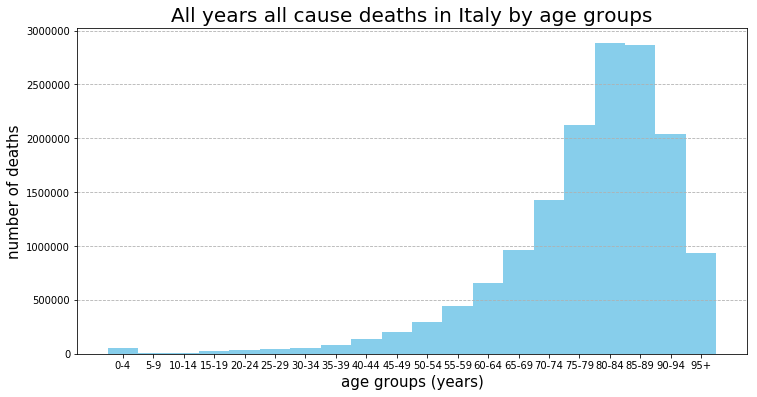

In [35]:
ITA_mortality_allyrs = mortality_allyrs[mortality_allyrs["Country"] == Italy].copy(deep=True)
print(ITA_mortality_allyrs.isnull().sum()) # check missingness
# group ages 0-4
ITA_mortality_allyrs["Deaths2_6"] = ITA_mortality_allyrs["Deaths2"] + ITA_mortality_allyrs["Deaths3"] +\
    ITA_mortality_allyrs["Deaths4"] + ITA_mortality_allyrs["Deaths5"] + ITA_mortality_allyrs["Deaths6"]
# add sum row
ITA_mortality_allyrs.loc["Total_deaths"] = ITA_mortality_allyrs.sum(axis=0, numeric_only=True)

# making the "histogram"
left = list(range(0, 100, 5))
height = [ITA_mortality_allyrs.loc["Total_deaths", "Deaths2_6"]]
height.extend(list(ITA_mortality_allyrs.iloc[-1, 15:-6]))
tick_label = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", \
              "60-64", "65-69", "70-74", "75-79", "80-84", "85-89", "90-94", "95+"]

fig0 = plt.figure(figsize=(12, 6))
plt1 = fig0.add_subplot(111)
plt1.bar(left, height, tick_label=tick_label, width=5, color=["skyblue"])
plt1.set_xlabel("age groups (years)", fontsize=15)
plt1.set_ylabel("number of deaths", fontsize=15)
plt.title("All years all cause deaths in Italy by age groups", fontsize=20)

plt.grid(axis="y", linestyle="--")
plt.show()

# Technical Report:
- While histogram is the preferred visualisation of such a distribution, the data comes in age bands which avoided the need to categorise continuous data into multiple bins. Therefore, a bar chart is plotted with no gaps to mimic a histogram. The data takes a highly negatively skewed distribution peaking at 80 to 89 years old. Number of deaths drop from 90 years on likely due to a much smaller population that lived up to that age. There is a slightly higher number of deaths at 0 to 4 years old than that for teenagers and young adults likely due to birth complications and paediatric diseases.

### B3. What were the top five causes of death (top five ICD-10 terms) in Italy across all years for the Neoplasm ICD10-category (C00-D48)?

In [36]:
# generating the table that focuses on Neoplasm causes of death by ICD-10 codes and their proportions
ITA_neoplasm_query = ITA_mortality_allyrs[["Cause", "Deaths1"]].query("Cause >= 'C00' and Cause < 'D49'")
ITA_neoplasm = pd.DataFrame(ITA_neoplasm_query.groupby(ITA_neoplasm_query.Cause).apply(lambda subf: subf["Deaths1"].sum()))
ITA_neoplasm.columns = ["Deaths"]
ITA_neoplasm.reset_index(inplace=True)
ITA_neoplasm["Deaths"] = ITA_neoplasm.Deaths.astype(int)
ITA_neoplasm["Proportion"] = ITA_neoplasm["Deaths"] / ITA_neoplasm["Deaths"].sum()

print(ITA_neoplasm.shape)
ITA_neoplasm.head(5)

(620, 3)


,Cause,Deaths,Proportion
0,C000,68,3.024022e-05
1,C001,355,1.578717e-04
2,C002,1,4.447091e-07
3,C004,1,4.447091e-07
4,C005,2,8.894182e-07


In [37]:
# data frame of top 5 proportions plus others 
ITA_top5 = ITA_neoplasm.sort_values(by=["Proportion"], ascending=False).iloc[:5, ]
ITA_top5.reset_index(drop=True, inplace=True)
other_deaths = ITA_neoplasm.Deaths.sum() - ITA_top5.Deaths.sum()
other_proportion = 1 - ITA_top5.Proportion.sum()
ITA_top5.loc[5] = ["others", other_deaths, other_proportion]
ITA_top5

,Cause,Deaths,Proportion
0,C349,426451,0.189647
1,C509,155895,0.069328
2,C189,143188,0.063677
3,C169,125679,0.055891
4,C259,120070,0.053396
5,others,1277378,0.568062


In [38]:
# inspecting lung/bronchus neoplasm cases that are specified (excluded by C34.9 unspecified)
ITA_neoplasm[ITA_neoplasm["Cause"].str.startswith("C34")]

,Cause,Deaths,Proportion
138,C340,572,0.000254
139,C341,2057,0.000915
140,C342,143,0.000064
141,C343,670,0.000298
142,C348,176,0.000078
143,C349,426451,0.189647


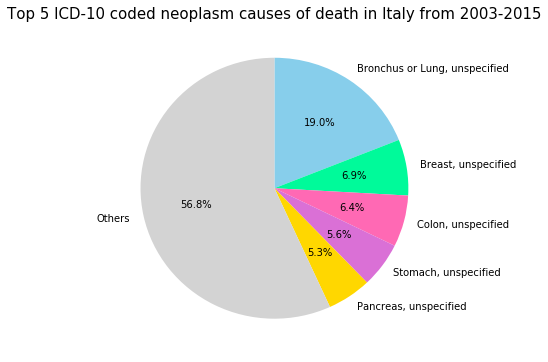

In [39]:
# pie chart for the data above
neoplasm = ["Bronchus or Lung, unspecified", "Breast, unspecified", "Colon, unspecified", "Stomach, unspecified",\
            "Pancreas, unspecified", "Others"]
colours = ["skyblue", "mediumspringgreen", "hotpink", "orchid", "gold", "lightgrey"]

fig1 = plt.figure(figsize=(6, 6))
plt1 = fig1.add_subplot(111)
plt1.pie(ITA_top5["Proportion"], labels=neoplasm, colors=colours, startangle=90, counterclock=False, autopct="%1.1f%%")
plt.title("Top 5 ICD-10 coded neoplasm causes of death in Italy from 2003-2015", fontsize=15)
plt.show()

# Technical Report:
- The top five neoplasm causes of death across all years (2003-2015) as recorded by ICD-10 in Italy are in descending order C34.9 (Malignant neoplasm: Bronchus or lung, unspecified; 19.0%), C50.9 (Malignant neoplasm: Breast, unspecified; 6.9%), C18.9 (Malignant neoplasm: Colon, unspecified; 6.4%), C16.9 (Malignant neoplasm: Stomach, unspecified; 5.6%), and C25.9 (Malignant neoplasm: Pancreas, unspecified; 5.3%). Bronchus and lung cancers take up almost a fifth of the pie and these 5 terms contributed to over one-third of all neoplasm causes of death.
- According to World Health Organisation which draws references from global burden of cancer studies, up to 2018 lung cancers are still the most prevalent and most common cause of cancer deaths (https://www.who.int/news-room/fact-sheets/detail/cancer). This is consistent with results from Italy. Breast, colorectal (including colon) and stomach cancers are also among the top 5 global cancer killers.
- However, it is important to address the problem with ICD-10 codes because all of the top 5 causes identified for Italy here are “unspecified”. For example, since only one code is used to represent the death cause, having C34.9 excludes cases with specified cases such as C34.1 (Malignant neoplasm: Upper lobe, bronchus or lung) and those 2,057 cases were not counted when comparing the top 5 ICD-10 terms recorded. Because different neoplasms have different ICD-10 granularity, some cancers may be more underrepresented than others. This is also affected by how the causes are coded, which is influenced by variation by individuals, department, hospitals, policies and so on. If this ICD-10 data is converted from a different local coding system, the process may introduce bias and possibly errors. While analyses of ICD-10 terms are still useful for obtaining an overview of the epidemiology, it is important to consider these biases and confounders when interpreting these results.

### B4. Are there differences by age group for deaths from Neoplasms (C00-D48) in Australia for 2010?
- Identify the top five age groups in Australia dying with a Neoplasms cause of death.

In [40]:
# top 5 age groups in AUS dying with neoplasm cause of death in 2010
Australia = country_lookup[country_lookup["name"] == "Australia"]["country"].item()
AUS_mortality_2010 = mortality_2010[mortality_2010["Country"] == Australia].copy(deep=True)
print(AUS_mortality_2010.isnull().sum()) # check missingness

AUS_neoplasm_2010_query = AUS_mortality_2010.query("Cause >= 'C00' and Cause < 'D49'")\
    .drop(["Country", "Admin1", "SubDiv", "Year", "List", "Sex", "Frmat", "IM_Frmat"], axis=1)
AUS_neoplasm_2010 = pd.DataFrame(AUS_neoplasm_2010_query.groupby(AUS_neoplasm_2010_query.Cause, as_index=False).sum())

AUS_neoplasm_2010.loc["Total_deaths"] = AUS_neoplasm_2010.sum(axis=0, numeric_only=True) # added final row as sums

AUS_neoplasm_2010.sort_values(by="Total_deaths", axis=1, ascending=False).iloc[-1, :6]

Country          0
Admin1        3777
SubDiv        3777
Year             0
List             0
Cause            0
Sex              0
Frmat            0
IM_Frmat         0
Deaths1          0
Deaths2          0
Deaths3          0
Deaths4          0
Deaths5          0
Deaths6          0
Deaths7          0
Deaths8          0
Deaths9          0
Deaths10         0
Deaths11         0
Deaths12         0
Deaths13         0
Deaths14         0
Deaths15         0
Deaths16         0
Deaths17         0
Deaths18         0
Deaths19         0
Deaths20         0
Deaths21         0
Deaths22         0
Deaths23         0
Deaths24         0
Deaths25         0
Deaths26         0
IM_Deaths1       0
IM_Deaths2       0
IM_Deaths3       0
IM_Deaths4       0
dtype: int64


Deaths1     43316
Deaths22     7167
Deaths21     6291
Deaths20     5713
Deaths23     5520
Deaths19     4768
Name: Total_deaths, dtype: object

In [41]:
# calculate proportion contributed by top 5 age groups
AUS_neoplasm_2010.sort_values(by="Total_deaths", axis=1, ascending=False).iloc[-1, 1:6].sum()/43316

0.6800951149690645

# Technical Report:
- Deaths1 in the above result corresponds to the sum of death in all age groups.
- In 2010, deaths caused by neoplasms in Australia were the highest in the age band of 80-84 years with a count of 7,167. In all 43,316 cancer deaths, this constitutes about one-sixth of the total (7167/43316 = 16.57%). The other groups in the top 5 are 75-79 (6,291 cases), 70-74 (5,713 cases), 85-89 (5,520 cases) and 65-69 (4,768 cases) in descending order. Together, in this year 68.01% of deaths by neoplasms occurred in people aged between 65 and 89 years old.

### B5. Compare and contrast the frequency of deaths by Neoplasms in Italy and Australia in 2010.

In [42]:
# Top 5 age groups in Italy with a neoplasm cause of death
ITA_mortality_2010 = mortality_2010[mortality_2010["Country"] == Italy].copy(deep=True)
ITA_neoplasm_2010_query = ITA_mortality_2010.query("Cause >= 'C00' and Cause < 'D49'")\
    .drop(["Country", "Admin1", "SubDiv", "Year", "List", "Sex", "Frmat", "IM_Frmat"], axis=1)
ITA_neoplasm_2010 = pd.DataFrame(ITA_neoplasm_2010_query.groupby(ITA_neoplasm_2010_query.Cause, as_index=False).sum())

ITA_neoplasm_2010.loc["Total_deaths"] = ITA_neoplasm_2010.sum(axis=0, numeric_only=True) # added final row as sums

ITA_neoplasm_2010.sort_values(by="Total_deaths", axis=1, ascending=False).iloc[-1, :6]

Deaths1     175046
Deaths22     31509
Deaths21     29884
Deaths20     25258
Deaths23     23794
Deaths19     17890
Name: Total_deaths, dtype: object

In [43]:
# calculate proportion contributed by top 5 age groups
ITA_neoplasm_2010.sort_values(by="Total_deaths", axis=1, ascending=False).iloc[-1, 1:6].sum()/175046

0.7331501433908801

# Technical Report:
- Focusing again on year 2010, the top 5 age groups with the highest deaths by neoplasm was inspected. The top group is the same as Australia which is 80-84 years old. In all 175,046 cancer deaths, this constitutes more than one-sixth of the total (31,509/175,046 = 18.00%). The remaining groups are 75-79 (29884 cases), 70-74 (25258 cases), 85-89 (23794 cases) and 65—69 (17890 cases) in descending order, which is the same ranking as Australia. However, in combination they contributed to 73.32% of all deaths by neoplasms, which is about 5% higher than in Australia. 

In [44]:
# calculating population, total mortality and % due to neoplasms for AUS and ITA
AUS_population_2010 = population_2010[population_2010["Country"] == Australia].copy(deep=True)
print(AUS_population_2010.isnull().sum()) # check missingness
AUS_popn = AUS_population_2010["Pop1"].sum().astype(int)
AUS_mort = AUS_mortality_2010["Deaths1"].sum()
AUS_mort_neoplasm = AUS_neoplasm_2010.loc["Total_deaths", "Deaths1"].astype(int) # total neoplasm deaths
print("In 2010, Australia's population was %s and the total number of deaths was %s." % (AUS_popn, AUS_mort))
print("Number of deaths due to neoplasms was %s (%.2f%%)." % (AUS_mort_neoplasm, (AUS_mort_neoplasm / AUS_mort) * 100))

# ITA_popn, ITA_mort available from previous tasks
ITA_mort_neoplasm = ITA_neoplasm_2010.loc["Total_deaths", "Deaths1"].astype(int) # total neoplasm deaths
print("In 2010, Italy's population was %s and the total number of deaths was %s." % (ITA_popn, ITA_mort))
print("Number of deaths due to neoplasms was %s (%.2f%%)." % (ITA_mort_neoplasm, (ITA_mort_neoplasm / ITA_mort) * 100))

Country    0
Admin1     2
SubDiv     2
Year       0
Sex        0
Frmat      0
Pop1       0
Pop2       0
Pop3       0
Pop4       0
Pop5       0
Pop6       0
Pop7       0
Pop8       0
Pop9       0
Pop10      0
Pop11      0
Pop12      0
Pop13      0
Pop14      0
Pop15      0
Pop16      0
Pop17      0
Pop18      0
Pop19      0
Pop20      0
Pop21      0
Pop22      0
Pop23      0
Pop24      0
Pop25      0
Pop26      0
Lb         0
dtype: int64
In 2010, Australia's population was 22297515 and the total number of deaths was 286946.
Number of deaths due to neoplasms was 43316 (15.10%).
In 2010, Italy's population was 60483386 and the total number of deaths was 1169230.
Number of deaths due to neoplasms was 175046 (14.97%).


# Technical Report:
- Considering the population structures in Australia and Italy, their populations and mortalities were compared. In 2010, Australia's population was 22,297,515 and the total number of deaths was 286,946. Among these deaths, 43,316 (15.10%) were due to neoplasms. Italy's population was 60,483,386 and the total number of deaths was 1,169,230. Among these deaths, 175,046 (14.97%) was due to neoplasms. Italy had roughly 4 times the population, deaths and deaths due to neoplasms compared to Australia, which is reflected in the similar percentage of deaths caused by cancers.

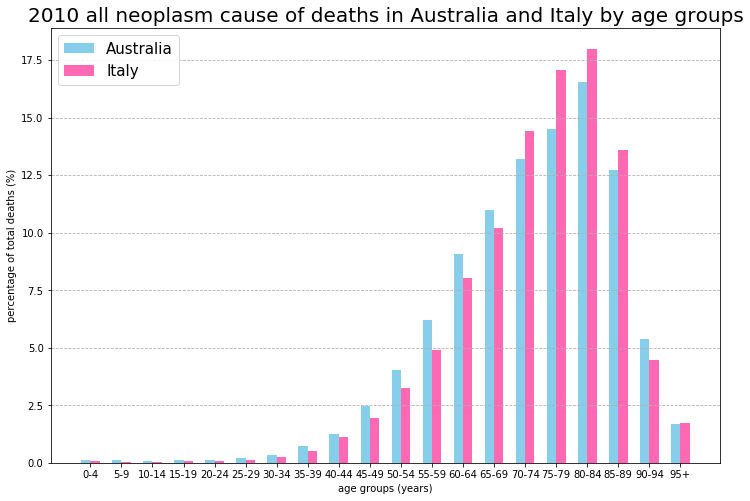

In [45]:
# all-neoplasm-cause distribution of death by age groups visualised as bars
# combining deaths of age 0, 1, 2, 3 and 4 to match other age bands' size
AUS_neoplasm_2010["Deaths2_6"] = AUS_neoplasm_2010["Deaths2"] + AUS_neoplasm_2010["Deaths3"] + AUS_neoplasm_2010["Deaths4"] +\
    AUS_neoplasm_2010["Deaths5"] + AUS_neoplasm_2010["Deaths6"]
ITA_neoplasm_2010["Deaths2_6"] = ITA_neoplasm_2010["Deaths2"] + ITA_neoplasm_2010["Deaths3"] + ITA_neoplasm_2010["Deaths4"] +\
    ITA_neoplasm_2010["Deaths5"] + ITA_neoplasm_2010["Deaths6"]

# creating lists of all sums of neoplasm deaths by age groups
height2_AUS = [AUS_neoplasm_2010.loc["Total_deaths", "Deaths2_6"]] # start by age 0-4
height2_AUS.extend(list(AUS_neoplasm_2010.iloc[-1, 7:26])) # final row is sum for each age group

height2_ITA = [ITA_neoplasm_2010.loc["Total_deaths", "Deaths2_6"]] # start by age 0-4
height2_ITA.extend(list(ITA_neoplasm_2010.iloc[-1, 7:26])) # final row is sum for each age group
tick_label = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", \
              "60-64", "65-69", "70-74", "75-79", "80-84", "85-89", "90-94", "95+"]

# inititate plot
fig3, ax = plt.subplots(figsize=(12, 8))

x = np.arange(20) # to specify 20 slots of age groups

plt1 = ax.bar(x, height2_AUS / AUS_mort_neoplasm * 100, 0.3, color="skyblue") # Australia bars
plt2 = ax.bar(x + 0.3, height2_ITA / ITA_mort_neoplasm * 100, 0.3, color="hotpink") # Italy bars shifted by 0.3 to the right

ax.set_title("2010 all neoplasm cause of deaths in Australia and Italy by age groups", fontsize=20)
ax.set_xticks(x + 0.3 / 2)
ax.set_xticklabels(tick_label)
ax.set_xlabel("age groups (years)")
ax.set_ylabel("percentage of total deaths (%)")

ax.legend((plt1[0], plt2[0]), ("Australia", "Italy"), fontsize=15)
ax.autoscale_view()

plt.grid(axis="y", linestyle="--")
plt.show()

# Technical Report:
- To compare their distributions by age groups, a bar chart can be used. However, since the overall number of deaths by neoplasms in Italy was about 4 times of Australia’s, it would be difficult to directly compare the distribution by age groups side-by-side. Instead, the proportions of total neoplasm deaths contributed by each age group were used instead for the ease of interpretation. As observed from the chart, both distributions have a similar shape with most deaths concentrated in older age groups. The relative proportions of each age groups are roughly the same for both countries. However, a slightly higher percentage is consistently observed for Australia from age group 0-4 up to 65-69 years old, which suggests more cancer deaths at younger ages in Australia than in Italy in 2010. In contrast, Italy has higher percentages of deaths in people aged 70 to 89.

In [46]:
# top 5 neoplasms causes of death in Australia in 2010
AUS_neoplasm_2010["Proportion"] = AUS_neoplasm_2010["Deaths1"] / AUS_mort_neoplasm
AUS_top5_2010 = AUS_neoplasm_2010.loc[:, ["Cause", "Deaths1", "Proportion"]].iloc[:-1, :]\
    .sort_values(by=["Proportion"], ascending=False).iloc[:5, ] #excluded Total_deaths row
AUS_top5_2010.reset_index(drop=True, inplace=True)
AUS_top5_2010["Deaths1"] = AUS_top5_2010.Deaths1.astype(int)
AUS_other_deaths_2010 = AUS_mort_neoplasm - AUS_top5_2010.Deaths1.sum()
AUS_other_proportion_2010 = 1 - AUS_top5_2010.Proportion.sum()
AUS_top5_2010.loc[5] = ["others", AUS_other_deaths_2010, AUS_other_proportion_2010]
print(AUS_top5_2010)

#  C34.9 Malignant neoplasm: Bronchus or lung, unspecified  
#  C61   Malignant neoplasm of prostate  
#  C50.9 Malignant neoplasm: Breast, unspecified  
#  C80.9 Malignant neoplasm, primary site unspecified  !!!!!
#  C25.9 Malignant neoplasm: Pancreas, unspecified  

    Cause  Deaths1  Proportion
0    C349     7989    0.184435
1     C61     3236    0.074707
2    C509     2865    0.066142
3    C809     2783    0.064249
4    C259     2367    0.054645
5  others    24076    0.555822


In [47]:
# top 5 neoplasms causes of death in Italy in 2010
ITA_neoplasm_2010["Proportion"] = ITA_neoplasm_2010["Deaths1"] / ITA_mort_neoplasm
ITA_top5_2010 = ITA_neoplasm_2010.loc[:, ["Cause", "Deaths1", "Proportion"]].iloc[:-1, :]\
    .sort_values(by=["Proportion"], ascending=False).iloc[:5, ] #excluded Total_deaths row
ITA_top5_2010.reset_index(drop=True, inplace=True)
ITA_top5_2010["Deaths1"] = ITA_top5_2010.Deaths1.astype(int)
ITA_other_deaths_2010 = ITA_mort_neoplasm - ITA_top5_2010.Deaths1.sum()
ITA_other_proportion_2010 = 1 - ITA_top5_2010.Proportion.sum()
ITA_top5_2010.loc[5] = ["others", ITA_other_deaths_2010, ITA_other_proportion_2010]
print(ITA_top5_2010)

#  C34.9 Malignant neoplasm: Bronchus or lung, unspecified  
#  C50.9 Malignant neoplasm: Breast, unspecified  
#  C18.9 Malignant neoplasm: Colon, unspecified  
#  C25.9 Malignant neoplasm: Pancreas, unspecified  
#  C16.9 Malignant neoplasm: Stomach, unspecified  

    Cause  Deaths1  Proportion
0    C349    33416    0.190898
1    C509    12231    0.069873
2    C189    11638    0.066485
3    C259     9683    0.055317
4    C169     9523    0.054403
5  others    98555    0.563023


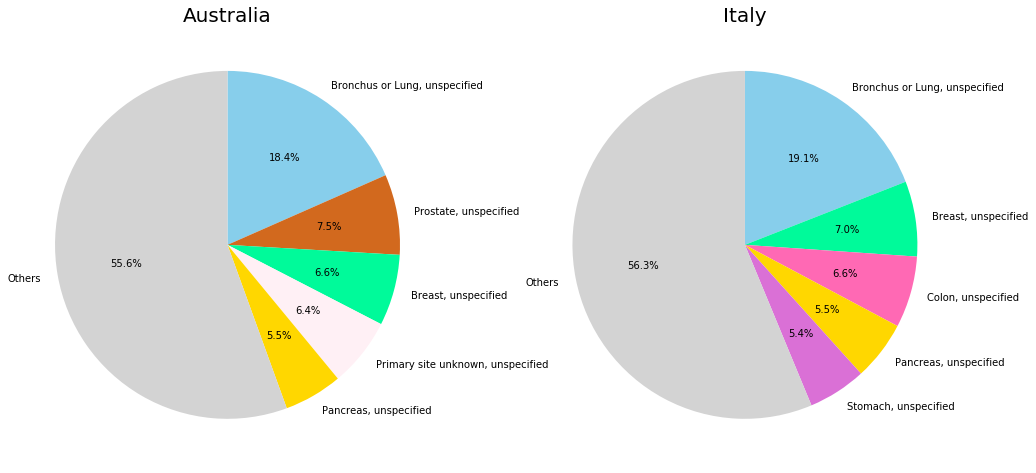

In [48]:
# visualising the data above
neoplasm1 = ["Bronchus or Lung, unspecified", "Prostate, unspecified", "Breast, unspecified",\
             "Primary site unknown, unspecified", "Pancreas, unspecified", "Others"]
neoplasm2 = ["Bronchus or Lung, unspecified", "Breast, unspecified", "Colon, unspecified", "Pancreas, unspecified",\
             "Stomach, unspecified", "Others"]
colours1 = ["skyblue", "chocolate", "mediumspringgreen", "lavenderblush", "gold", "lightgrey"]
colours2 = ["skyblue", "mediumspringgreen", "hotpink", "gold", "orchid", "lightgrey"]

fig2 = plt.figure(figsize=(17, 8)) #create a figure

plt1 = fig2.add_subplot(121)
plt2 = fig2.add_subplot(122)

plt1.pie(AUS_top5_2010["Proportion"], labels=neoplasm1, colors=colours1, startangle=90, counterclock=False, autopct="%1.1f%%")
plt1.set_title("Australia", fontsize=20)

plt2.pie(ITA_top5_2010["Proportion"], labels=neoplasm2, colors=colours2, startangle=90, counterclock=False, autopct="%1.1f%%")
plt2.set_title("Italy", fontsize=20)

fig2.subplots_adjust(hspace=.2,wspace=.2)
plt.show()

# Technical Report:
- Another perspective to look at the neoplasm cause of deaths in both countries is by the most frequent causes as recorded by ICD-10 terms. For Italy, the top 5 causes in 2010 are the same as when inspecting all years (2003-2015) with roughly the same proportions, except for a switch in rank of pancreas and stomach cancers. For Australia, the top 5 causes are C34.9 (Malignant neoplasm: Bronchus or lung, unspecified), C61 (Malignant neoplasm of prostate), C50.9 (Malignant neoplasm: Breast, unspecified), C80.9 (Malignant neoplasm, primary site unspecified) and C25.9 (Malignant neoplasm: Pancreas, unspecified) in descending order. While the top cause of bronchus and lung cancers is the same, the others are a bit different. Breast cancer and pancreas cancer are still on the list. The former has a slightly smaller proportion than Italy while the latter is about the same. Prostate cancer, which is not on Italy’s top 5, is the second largest neoplasm cause of death in Australia in 2010. Colon cancer and stomach cancer are not on the list for Australia. It would be interesting to see if genetics and diet have an effect here. The fourth largest cause in Australia is interestingly “primary site unknown, unspecified” which can be any type of cancers. The reason behind should be investigated. It is possible that in-depth coding of cancer deaths is not required in certain Australian clinical settings, there are mismatches between records and death registries, or there is information loss in the coding or conversion process.

End of Document